### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Load and visualize the data

Names of arrays: ['u', 'th']
Shape of u and th: (35000,) (35000,)
Reshaped data of u and th: (35000, 1) (35000, 1)


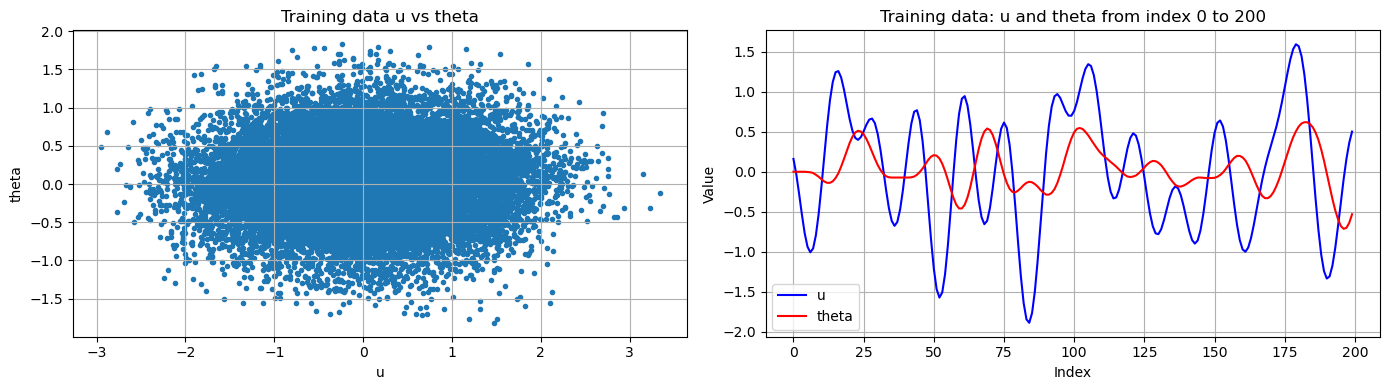

In [2]:
# Map the file names and paths
file_map = {
    "train_val_test": "disc-benchmark-files/training-val-test-data.npz",
    "hidden_test_pred": "disc-benchmark-files/hidden-test-prediction-submission-file.npz",
    "hidden_test_sim": "disc-benchmark-files/hidden-test-simulation-submission-file.npz"
}

file_name = file_map["train_val_test"]  

# Load the data 
data = np.load(file_name)
print("Names of arrays:", data.files)
print("Shape of u and th:", data['u'].shape, data['th'].shape)

# Reshape the data 
u = data['u'].reshape(-1,1)
th = data['th'].reshape(-1,1)
print("Reshaped data of u and th:", u.shape, th.shape)

# Define the division of the data for training, validation and testing
N = len(u)
train_percent = 0.70
val_test_percent = (1-train_percent) / 2

# Split data in training, testing and validation
n_train = int(train_percent * N)
n_val   = int(val_test_percent * N)

# Split dat in train val and test sets
u_train = u[:n_train]
y_train = th[:n_train]
u_val = u[n_train:n_train+n_val]
y_val   = th[n_train:n_train+n_val]
u_test = u[n_train+n_val:] 
y_test  = th[n_train+n_val:]


# Start and end index for plotting data data 
start, end = 0, 200

# Define the subplot layout
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# Plot the data, scatter and line plot 
axs[0].scatter(u_train, y_train, marker='.')
axs[0].set_title('Training data u vs theta')
axs[0].set_xlabel('u')
axs[0].set_ylabel('theta')
axs[0].grid(True)

axs[1].plot(u_train[start:end], label='u', color='b')
axs[1].plot(y_train[start:end], label='theta', color='r')
axs[1].set_title(f'Training data: u and theta from index {start} to {end}')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Create hyperparameters and function for features

In [ ]:
# Hyperparameter ranges for random search
param_ranges = {
    'L_th': (2, 8),       
    'L_u': (2, 8),           
    'num_inducing': (2, 15) 
}

# Define number of trails for a random search
n_trials = 100  

def build_features(u, th, L_th, L_u, max_lag, N_eff):
    # Initialize X and Y
    X = np.zeros((N_eff, L_th + L_u))
    Y = np.zeros(N_eff)
    # Fill in X and Y
    for i in range(N_eff):
        k = max_lag + i
        # past L_th thetas and L_u inputs
        y_lags = [th[k-j, 0] for j in range(1, L_th+1)]
        u_lags = [u [k-j, 0] for j in range(1, L_u +1)]
        X[i, :] = y_lags + u_lags
        Y[i] = th[k, 0]

    return X, Y

### Do a random grid search for optimal hyperparameters

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done  82 out of 100 | elapsed:  1.4min remaining:   17.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


Best hyperparameters found: {'L_th': 8, 'L_u': 2, 'num_inducing': 15, 'rmse': 0.0038552199109205794}
Correlation of hyperparameters with RMSE: L_th           -0.075484
L_u             0.224396
num_inducing   -0.326485
Name: rmse, dtype: float64


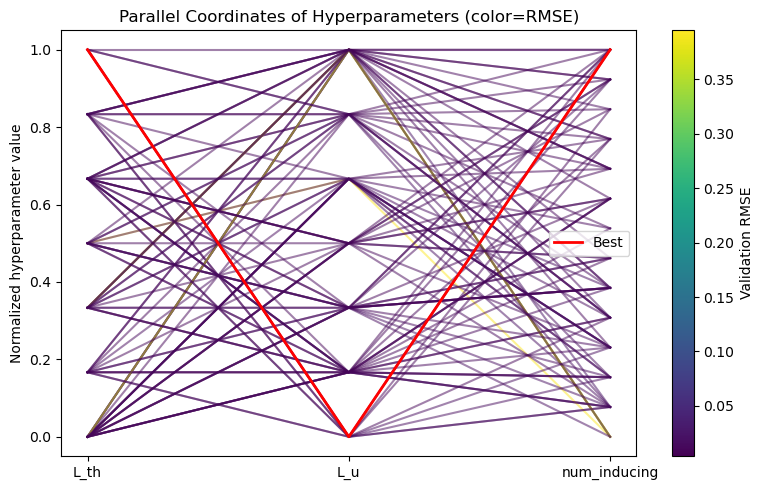

In [4]:
# === Initialize for tuning ===
from tqdm import trange

results = []  # will store dicts of hyperparams and RMSE
best = {'rmse': np.inf}

# Cache for feature builds to avoid recomputation
feature_cache = {}

# Parallel execution of trials using Joblib
from joblib import Parallel, delayed

def trial(t):
    L_th = np.random.randint(param_ranges['L_th'][0], param_ranges['L_th'][1] + 1)
    L_u = np.random.randint(param_ranges['L_u'][0], param_ranges['L_u'][1] + 1)
    num_inducing = np.random.randint(param_ranges['num_inducing'][0], param_ranges['num_inducing'][1] + 1)
    max_lag = max(L_th, L_u)
    N_eff = len(u) - max_lag

    # Build features and splits based on sampled lags
    X_all, Y_all = build_features(u, th, L_th, L_u, max_lag, N_eff)
    train_end = N_eff - n_val
    X_train, Y_train = X_all[:train_end], Y_all[:train_end]
    X_val, Y_val = X_all[train_end:], Y_all[train_end:]

    # Train sparse GP
    kernel = GPy.kern.RBF(input_dim=X_train.shape[1], ARD=True)
    # Randomly pick some inducing points from the training data 
    Z = X_train[np.random.choice(len(X_train), num_inducing, replace=False)]
    model = GPy.models.SparseGPRegression(X_train, Y_train[:, None], kernel=kernel, Z=Z)
    model.optimize(messages=False, max_iters=100)

    # Evaluate on validation set
    Y_pred, _ = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))
    print(f"Trial {t+1}/{n_trials}: L_th={L_th}, L_u={L_u}, inducing={num_inducing}, resulting RMSE={rmse}")
    return {'L_th': L_th, 'L_u': L_u, 'num_inducing': num_inducing, 'rmse': rmse}

# Do in parallel
results = Parallel(n_jobs=-1, verbose=5)(delayed(trial)(t) for t in range(n_trials))

# Take the best result
best = {'rmse': np.inf}
for res in results:
    if res['rmse'] < best['rmse']:
        best = res

print("Best hyperparameters found:", best)

results_df = pd.DataFrame(results)

corrs = results_df.corr()['rmse'].drop('rmse')
print("Correlation of hyperparameters with RMSE:", corrs)

scaler = MinMaxScaler()
norm_params = scaler.fit_transform(results_df[['L_th', 'L_u', 'num_inducing']])

fig, ax = plt.subplots(figsize=(8, 5))
x = [0, 1, 2]
labels = ['L_th', 'L_u', 'num_inducing']

for i, vals in enumerate(norm_params):
    ax.plot(x, vals, color=plt.cm.viridis(results_df['rmse'].iloc[i] / results_df['rmse'].max()), alpha=0.5)

best_vals = scaler.transform(pd.DataFrame([best])[['L_th', 'L_u', 'num_inducing']])[0]
ax.plot(x, best_vals, color='red', linewidth=2, label='Best')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Normalized hyperparameter value')
plt.title('Parallel Coordinates of Hyperparameters (color=RMSE)')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=results_df['rmse'].min(), vmax=results_df['rmse'].max()))
sm.set_array([])
plt.colorbar(sm, label='Validation RMSE')
plt.legend()
plt.tight_layout()
plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0003  -1.255469e+03   1.196279e+08 
    03s25  0054  -1.156305e+05   2.545019e+07 
    11s46  0189  -1.203436e+05   1.006925e+07 
    33s84  0559  -1.222290e+05   5.138821e+05 
    51s41  0853  -1.225359e+05   2.422514e+06 
Runtime:     51s41
Optimization status: Converged

Test RMSE: 0.003794


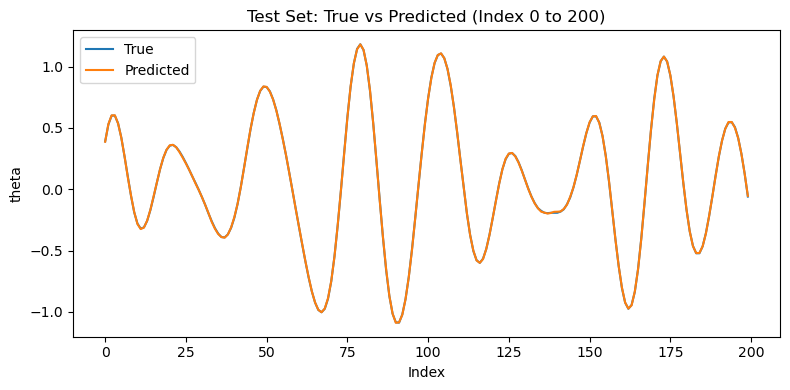

In [5]:
L_th_b, L_u_b, num_ind_b = best['L_th'], best['L_u'], best['num_inducing']
max_lag = max(L_th_b, L_u_b)
N_eff = len(u) - max_lag
X_all, Y_all = build_features(u, th, L_th_b, L_u_b, max_lag, N_eff)


n_eff_train = n_train - max_lag


X_tv, Y_tv = X_all[:n_eff_train + n_val], Y_all[:n_eff_train + n_val]
X_test, Y_test = X_all[n_eff_train + n_val:], Y_all[n_eff_train + n_val:]

kernel = GPy.kern.RBF(input_dim=X_tv.shape[1], ARD=True)
Z_tv = X_tv[np.random.choice(len(X_tv), num_ind_b, replace=False)]
final_model = GPy.models.SparseGPRegression(X_tv, Y_tv[:, None], kernel=kernel, Z=Z_tv)
final_model.optimize(messages=True, max_iters=2000)

# Evaluate on test set
Y_test_pred, _ = final_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
print(f"Test RMSE: {test_rmse:.6f}")

# Plot test predictions for the first 100 indices using start and end
plt.figure(figsize=(8, 4))
plt.plot(Y_test[start:end], label='True')
plt.plot(Y_test_pred[start:end], label='Predicted')
plt.title(f'Test Set: True vs Predicted (Index {start} to {end})')
plt.xlabel('Index')
plt.ylabel('theta')
plt.legend()
plt.tight_layout()
plt.show()